# GradCAM on Cora dataset for 2-layer GCN

In [1]:
from dig.xgraph.dataset import SynGraphDataset
from dig.xgraph.models import *
import torch
from torch_geometric.data import DataLoader
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_zip
import os.path as osp
import os

import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from dig.xgraph.models import GCN_2l

from torch_geometric.nn.models.gnn_explainer import GNNExplainer
from torch_geometric.utils import add_self_loops
import matplotlib.pyplot as plt


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load dataset

In [2]:
dataset_name = 'Cora'
path = "./datasets/Planetoid/"
dataset = Planetoid(path, dataset_name, transform=T.NormalizeFeatures())

dim_node = dataset.num_node_features
dim_edge = dataset.num_edge_features
num_classes = dataset.num_classes

### Load model and train

In [3]:
model = GCN_2l(model_level='node', dim_node=dim_node, dim_hidden=128, num_classes=num_classes)
model = model.to(device)
data = dataset.data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model

GCN_2l(
  (conv1): GCNConv(1433, 128)
  (convs): ModuleList(
    (0): GCNConv(128, 128)
  )
  (relu1): ReLU()
  (relus): ModuleList(
    (0): ReLU()
  )
  (readout): IdenticalPool()
  (ffn): Sequential(
    (0): Linear(in_features=128, out_features=7, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    log_logits = F.log_softmax(out, dim=1)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:3d}, loss: {loss.item():.4f}")
    loss.backward()
    optimizer.step()

Epoch:  10, loss: 0.0105
Epoch:  20, loss: 0.0000
Epoch:  30, loss: 0.0000
Epoch:  40, loss: 0.0005
Epoch:  50, loss: 0.0021
Epoch:  60, loss: 0.0027
Epoch:  70, loss: 0.0032
Epoch:  80, loss: 0.0036
Epoch:  90, loss: 0.0035
Epoch: 100, loss: 0.0032
Epoch: 110, loss: 0.0030
Epoch: 120, loss: 0.0030
Epoch: 130, loss: 0.0029
Epoch: 140, loss: 0.0029
Epoch: 150, loss: 0.0028
Epoch: 160, loss: 0.0028
Epoch: 170, loss: 0.0028
Epoch: 180, loss: 0.0028
Epoch: 190, loss: 0.0028
Epoch: 200, loss: 0.0028


In [5]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

print(f"Test accuracy: {test()*100:.2f}")

Test accuracy: 79.40


### GradCAM Training

In [6]:
from dig.xgraph.method import GradCAM
explainer = GradCAM(model, explain_graph=False)

# --- Set the Sparsity to 0.5 ---
sparsity = 0.5

# --- Create data collector and explanation processor ---
from dig.xgraph.evaluation import XCollector, ExplanationProcessor
x_collector = XCollector(sparsity)
# x_processor = ExplanationProcessor(model=model, device=device)

In [7]:
node_idx = 10
walks, masks, related_preds = explainer(data.x, data.edge_index,
                                        node_idx=torch.tensor(node_idx, requires_grad=False),
                                        sparsity=sparsity, num_classes=num_classes)

/home/sakkas/softwares/anaconda3/envs/pyg1.7/lib/python3.8/site-packages/captum/attr/_utils/gradient.py:31: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


masks contain edge masks for each class. Note that DIG implementation adds self loops. Therefore, I added self loops 
too.  


### Visualization  
I just use GNNExplainer for visualization. DIG visualization implementation gives lots of errors.

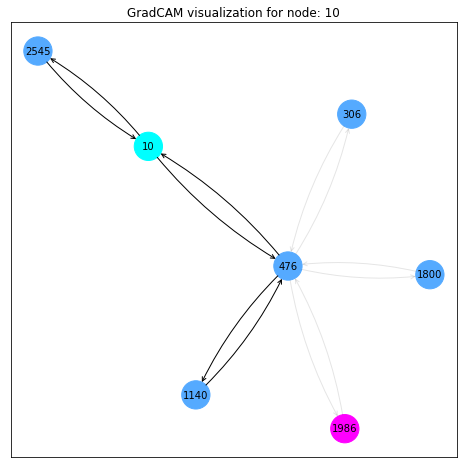

In [8]:
self_looped_edge_index = add_self_loops(data.edge_index)[0]

gnn_explainer = GNNExplainer(model, epochs=200, return_type='log_prob')# just use it for visualization


plt.figure(figsize=(8,8))
ax, G = gnn_explainer.visualize_subgraph(node_idx, self_looped_edge_index, 
                                         masks[data.y[node_idx]], y=data.y)

plt.title(f'GradCAM visualization for node: {node_idx}')
plt.show()

### Another Example

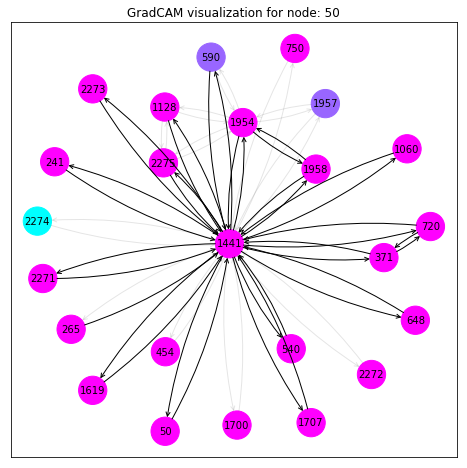

In [9]:
node_idx = 50

walks, masks, related_preds = explainer(data.x, data.edge_index,
                                        node_idx=torch.tensor(node_idx, requires_grad=False),
                                        sparsity=sparsity, num_classes=num_classes)

plt.figure(figsize=(8,8))
ax, G = gnn_explainer.visualize_subgraph(node_idx, self_looped_edge_index, 
                                         masks[data.y[node_idx]], y=data.y)

 
plt.title(f'GradCAM visualization for node: {node_idx}')
plt.show()